# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on MnPO cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1.3 M brain cells with Unified Virtual Memory to oversubscribe GPU memory.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata
import scipy.io
import scipy.sparse

import time
import os, wget


import cudf

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import cuml
import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import rmm

from rmm.allocators.cupy import rmm_cupy_allocator
import cupy
cupy.cuda.set_allocator(rmm_cupy_allocator)
from scipy import sparse
import gc
import cupy as cp
gc.collect()
cp.get_default_memory_pool().free_all_blocks()
import calculation_tool as ct

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [2]:

url=r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM4663168&format=file&file=GSM4663168%5F3%2DOVLT%2Dregional%2Dsingle%2Dcell%2Ecsv%2Egz"
input_file="/data/mouse_OVLT/GSM4663168_3-OVLT-regional-single-cell.csv.gz"
input_csv="/data/mouse_OVLT/GSM4663168_3-OVLT-regional-single-cell.csv"
if not os.path.exists(input_csv):
    print('Downloading import file...')
    os.makedirs('/data/mouse_OVLT', exist_ok=True)
    wget.download(url,input_file)

results_file = "/data/mouse_mouse_OVLT/ovlt_ctrl.h5ad"

In [3]:

url=r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM4663173&format=file&file=GSM4663173%5F10%2DOVLT%2Dstimulus%2Dto%2Dcell%2Dtype%2Dmapping%2Dwater%5Fsated%2Ecsv%2Egz"
input_file="/data/mouse_OVLT/GSM4663173_10-OVLT-stimulus-to-cell-type-mapping-water_sated.csv.gz"
input_csv="/data/mouse_OVLT/GSM4663173_10-OVLT-stimulus-to-cell-type-mapping-water_sated.csv"
if not os.path.exists(input_csv):
    print('Downloading import file...')
    os.makedirs('/data/mouse_OVLT', exist_ok=True)
    wget.download(url,input_file)

In [4]:

url=r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM4663174&format=file&file=GSM4663174%5F11%2DOVLT%2Dstimulus%2Dto%2Dcell%2Dtype%2Dmapping%2Dosmotic%5Fthirst%2Ecsv%2Egz"
input_file="/data/mouse_OVLT/GSM4663174_11-OVLT-stimulus-to-cell-type-mapping-osmotic_thirst.csv.gz"
input_csv="/data/mouse_OVLT/GSM4663174_11-OVLT-stimulus-to-cell-type-mapping-osmotic_thirst.csv"
if not os.path.exists(input_csv):
    print('Downloading import file...')
    os.makedirs('/data/mouse_OVLT', exist_ok=True)
    wget.download(url,input_file)

In [5]:

url=r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM4663175&format=file&file=GSM4663175%5F12%2DOVLT%2Dstimulus%2Dto%2Dcell%2Dtype%2Dmapping%2Dhypovolemic%5Fthirst%2Ecsv%2Egz"
input_file="/data/mouse_OVLT/GSM4663175_12-OVLT-stimulus-to-cell-type-mapping-hypovolemic_thirst.csv.gz"
input_csv="/data/mouse_OVLT/GSM4663175_12-OVLT-stimulus-to-cell-type-mapping-hypovolemic_thirst.csv"
if not os.path.exists(input_csv):
    print('Downloading import file...')
    os.makedirs('/data/mouse_OVLT', exist_ok=True)
    wget.download(url,input_file)

In [6]:

url=r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM4663176&format=file&file=GSM4663176%5F13%2DOVLT%2Dstimulus%2Dto%2Dcell%2Dtype%2Dmapping%2D36H%5Fwater%5Fdeprivation%2Ecsv%2Egz"
input_file="/data/mouse_OVLT/GSM4663176_13-OVLT-stimulus-to-cell-type-mapping-36H_water_deprivation.csv.gz"
input_csv="/data/mouse_OVLT/GSM4663176_13-OVLT-stimulus-to-cell-type-mapping-36H_water_deprivation.csv"
if not os.path.exists(input_csv):
    print('Downloading import file...')
    os.makedirs('/data/mouse_OVLT', exist_ok=True)
    wget.download(url,input_file)

In [7]:
from sh import gunzip
import glob
dir="/data/mouse_OVLT/"
gz_list=glob.glob(os.path.join(dir,"GSM*.gz"))
for gz in gz_list:
    gunzip(gz)


In [8]:
import glob
dir="/data/mouse_OVLT/"
csv_list=glob.glob(os.path.join(dir,"GSM*.csv"))


In [ ]:
from scipy import sparse
csv_list
label_list=["plane","water_sated","osmotic_thirst","hypovolemic_thirst","water_deprivation"]
all_adatas = []
for i,csv in enumerate(csv_list):
    print(csv)
    adata=sc.read_csv(csv)
    adata=adata.transpose()
    sparse_X = sparse.csr_matrix(adata.X)
    adata.X = sparse_X
    adata.obs['label'] = label_list[i]
    all_adatas.append(adata)
    
combined_adata = all_adatas[0].concatenate(all_adatas[1:], join='outer')
combined_adata.write("/data/mouse_OVLT/combined_data.h5ad")

/data/mouse_OVLT/GSM4663168_3-OVLT-regional-single-cell.csv
/data/mouse_OVLT/GSM4663173_10-OVLT-stimulus-to-cell-type-mapping-water_sated.csv
/data/mouse_OVLT/GSM4663174_11-OVLT-stimulus-to-cell-type-mapping-osmotic_thirst.csv
/data/mouse_OVLT/GSM4663175_12-OVLT-stimulus-to-cell-type-mapping-hypovolemic_thirst.csv
/data/mouse_OVLT/GSM4663176_13-OVLT-stimulus-to-cell-type-mapping-36H_water_deprivation.csv


In [10]:
combined_adata.var_names

Index(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', '0610009O20Rik',
       '0610010F05Rik', '0610010K14Rik', '0610012D04Rik', '0610012G03Rik',
       '0610025J13Rik', '0610030E20Rik',
       ...
       'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4',
       'mt-Nd4l', 'mt-Nd5', 'mt-Nd6'],
      dtype='object', length=30801)

In [ ]:
genes=adata.var_names
pd.DataFrame(genes).to_csv("/temp/data/mouse_SFO/WT_SFO_adata_genes.csv")

preprocess_in_bulk
HTR1E is not included
HTR1E is removed from marker list
['CX3CR1', 'CLDN5', 'GLUL', 'NDRG2', 'PCDH15', 'PLP1', 'MBP', 'SATB2', 'SLC17A7', 'SLC17A6', 'GAD2', 'GAD1', 'SNAP25', 'HTR1A', 'HTR1B', 'HTR1D', 'HTR2A', 'HTR2B', 'HTR2C', 'HTR3A', 'HTR4', 'HTR5A', 'HTR6', 'HTR7', 'DRD1', 'DRD2', 'DRD3', 'DRD4', 'DRD5', 'HRH1', 'HRH2', 'HRH3', 'CHRM1', 'CHRM2', 'CHRM3', 'CHRM4', 'CHRM5', 'ADRA1A', 'ADRA1B', 'ADRA2A', 'ADRA2B', 'ADRA2C', 'ADRB1', 'ADRB2', 'NOS1', 'CAMK2A', 'CAMK2B', 'ETV1', 'RXFP1', 'PDYN']
perform regression
perform scale
float32
Total Preprocessing time: 16.96619415283203
shape of adata: (33102, 25281)
shape of adata: (33102, 25281)
perform PCA
10
t-sne
UMAP
[2025-04-11 23:56:09.618] [CUML] [info] build_algo set to brute_force_knn because random_state is given
UMAP louvain


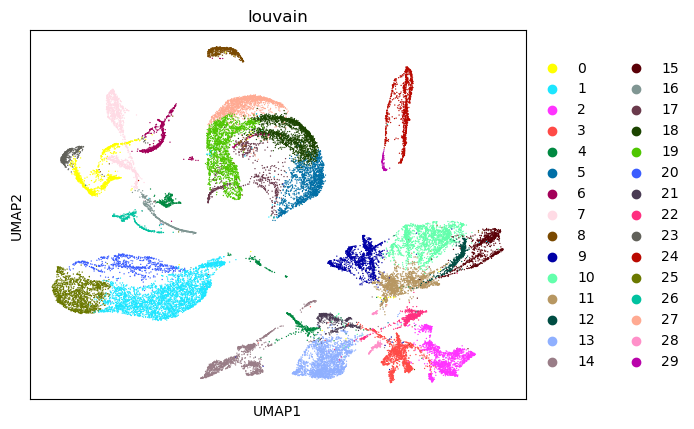

UMAP leiden


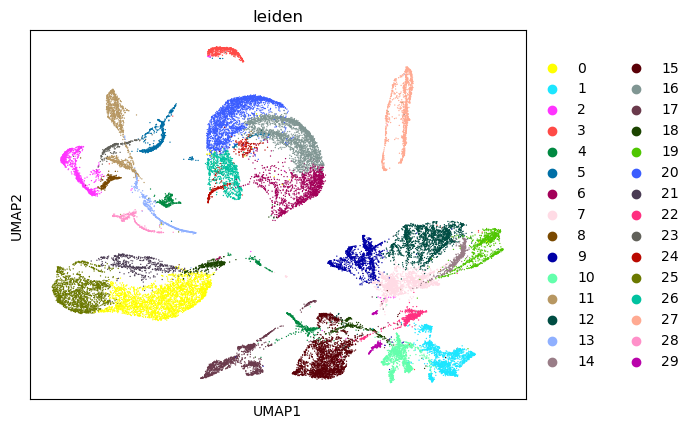

calc drug response
clz selective cells
# of clz selective cells: is_clz_selective
False    29868
True      3234
Name: count, dtype: int64


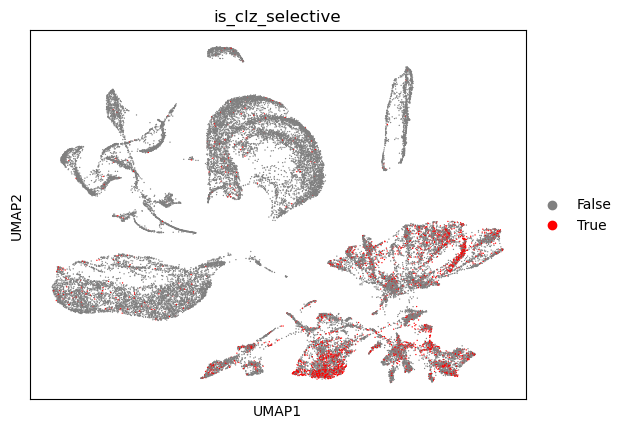

In [11]:
import calculation_tool as ct
file_path="/data/mouse_OVLT/combined_data.h5ad"
add_markers=["NOS1","CAMK2A","CAMK2B","ETV1","RXFP1","PDYN"]
adata,GPCR_df=ct.preprocess_adata_in_bulk(file_path,label=None,add_markers=add_markers,is_gpu=False)
GPCR_df.to_csv("/data/mouse_OVLT/combined_data_GPCR_df.csv")

In [3]:
file_path="/data/mouse_SFO/WT_SFO_adata_processed.h5ad"
adata=sc.read_h5ad(file_path)

In [4]:
GPCR_df=pd.read_csv("/data/mouse_OVLT/combined_data_GPCR_df.csv")

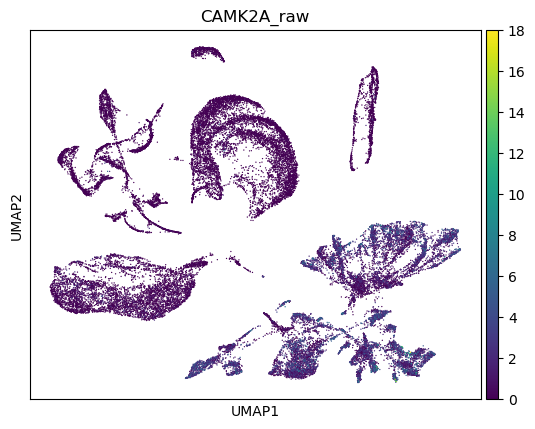

In [12]:
sc.pl.umap(adata, color=["CAMK2A_raw"])

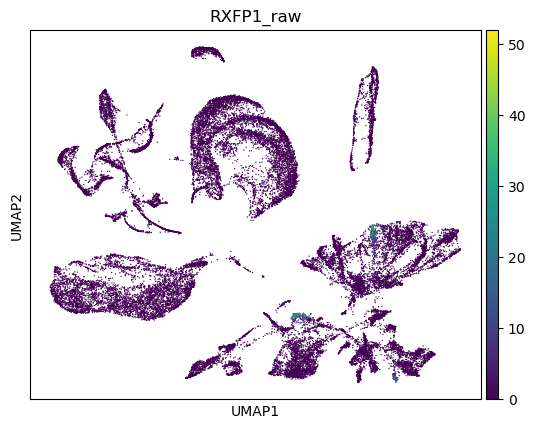

In [13]:
sc.pl.umap(adata, color=["RXFP1_raw"])

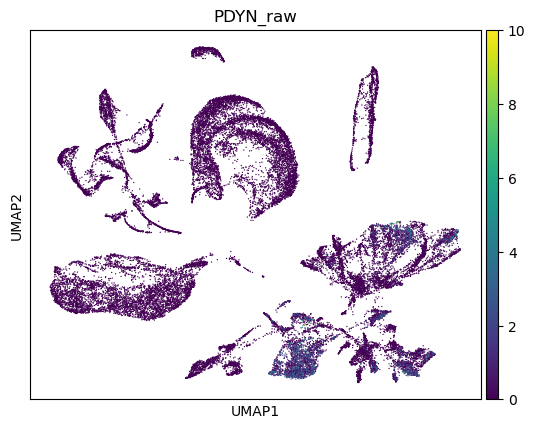

In [14]:
sc.pl.umap(adata, color=["PDYN_raw"])

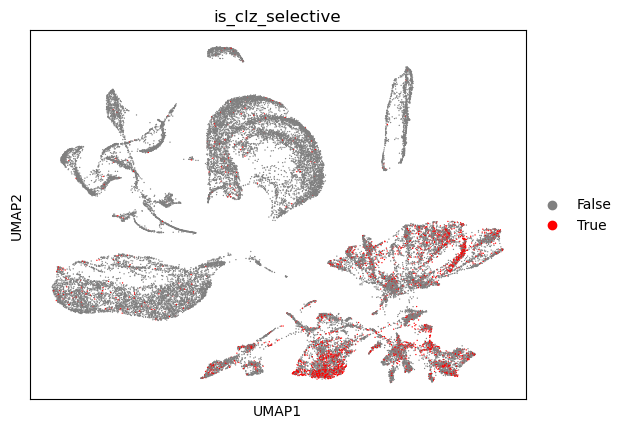

In [15]:
sc.pl.umap(adata, color=["is_clz_selective"],palette=["grey","red"])

In [6]:
file_path="/data/mouse_OVLT/combined_data_processed.h5ad"
adata=anndata.read_h5ad(file_path)

In [4]:
GPCR_df=pd.read_csv("/data/mouse_OVLT/combined_data_GPCR_df.csv")

In [7]:
nos1_expression=adata.obs["NOS1_raw"]

(array([3.0612e+04, 1.7830e+03, 4.1100e+02, 2.1100e+02, 4.5000e+01,
        3.0000e+01, 6.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([ 0.        ,  2.5999999 ,  5.19999981,  7.80000019, 10.39999962,
        13.        , 15.60000038, 18.20000076, 20.79999924, 23.39999962,
        26.        ]),
 <BarContainer object of 10 artists>)

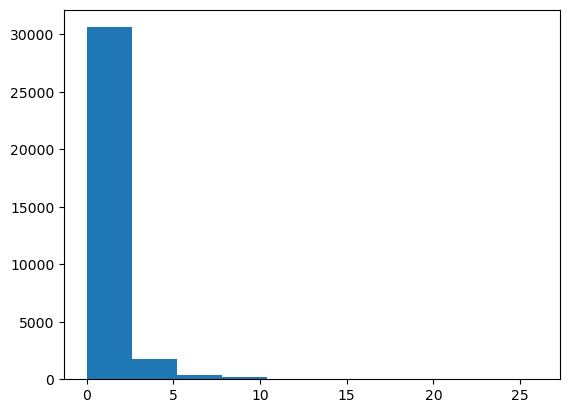

In [8]:
plt.hist(nos1_expression)

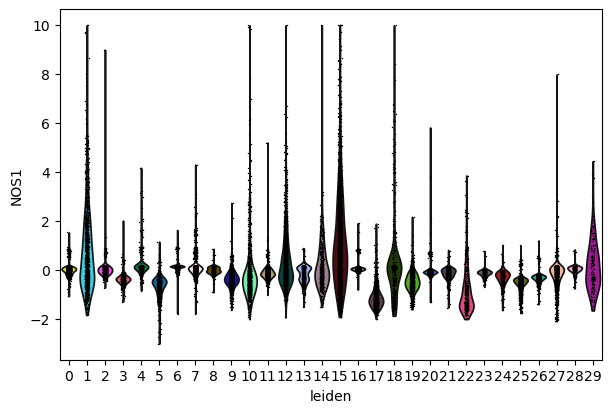

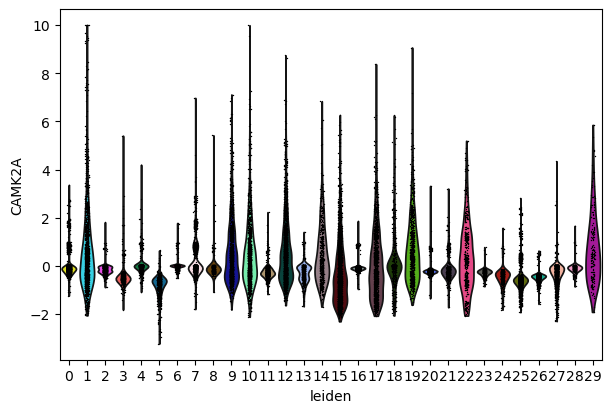

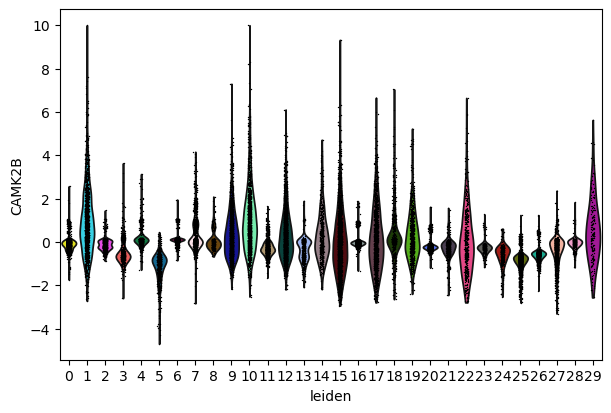

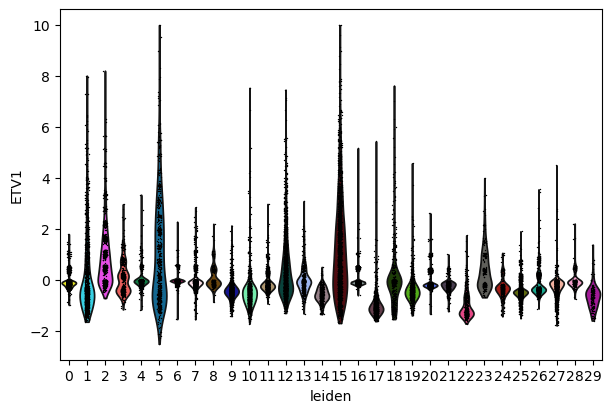

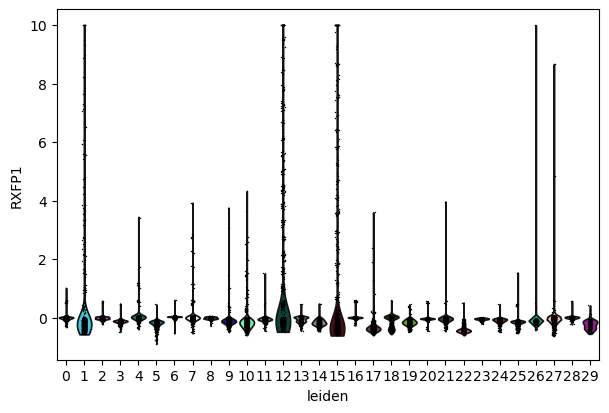

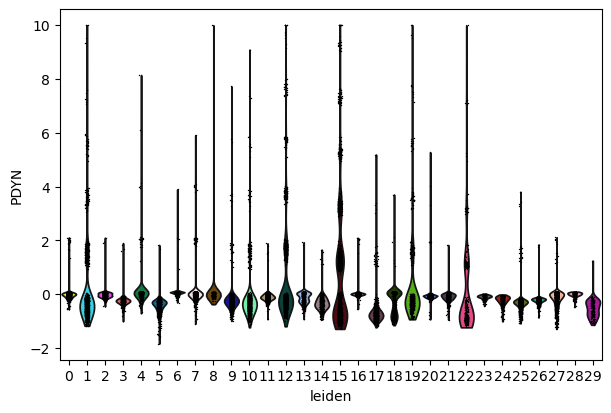

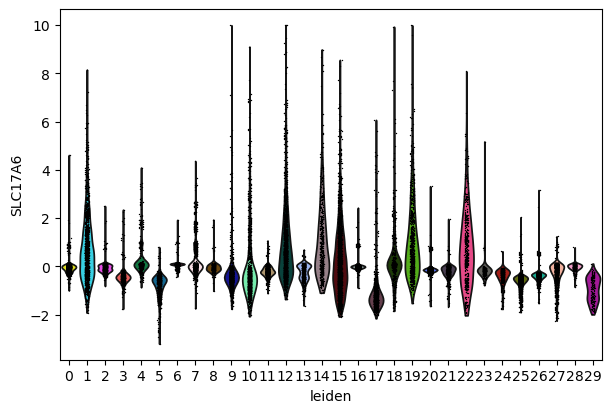

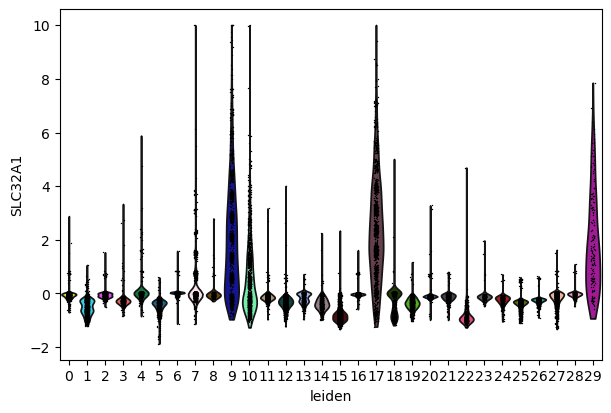

In [16]:
import matplotlib.pyplot as plt

add_markers = ["NOS1", "CAMK2A", "CAMK2B", "ETV1", "RXFP1", "PDYN", "SLC17A6", "SLC32A1"]  # SLC17A6=VGLUT2, SLC32A1=VGAT
for marker in add_markers:
    # show=False にすることでプロットを描画せずに Axes オブジェクトを返す
    ax = sc.pl.violin(adata, marker, groupby='leiden', show=False)
    
    # Axes オブジェクトのレジェンドを取得して削除
    legend = ax.get_legend()
    if legend is not None:
        legend.remove()
    
    # プロットを表示
    plt.show()

In [11]:
#thirst_cell_leiden=[4,12]
thirst_cell_leiden=[1,12,15]
adata.obs["is_thirst"] = np.where(adata.obs["leiden"].isin(thirst_cell_leiden), 1, 0)
adata.obs["is_thirst"] =adata.obs["is_thirst"].astype("category")

In [6]:

adata.obs["is_RXFP1"] = adata.obs["RXFP1_raw"]>1
adata.obs["is_RXFP1"] =adata.obs["is_RXFP1"].astype("category")

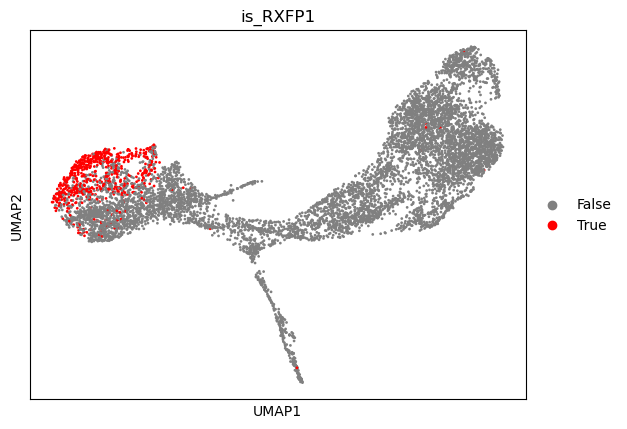

In [7]:
sc.pl.umap(adata, color=["is_RXFP1"],palette=["grey","red"])

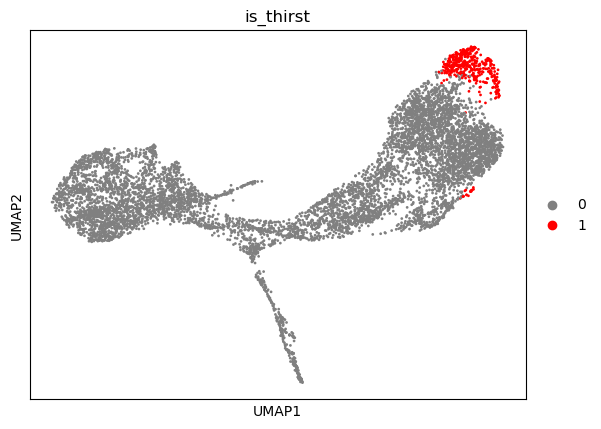

In [12]:
sc.pl.umap(adata, color=["is_thirst"],palette=["grey","red"])

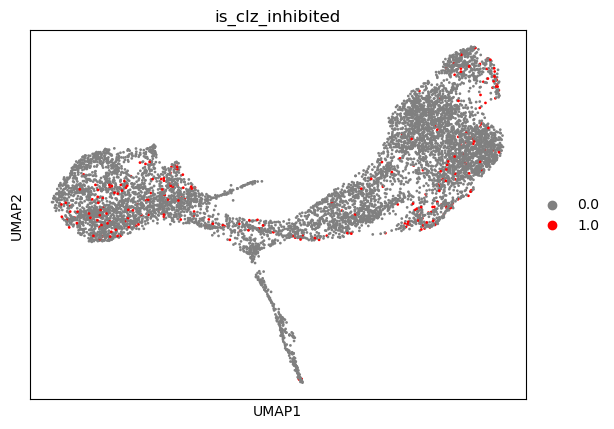

In [13]:
sc.pl.umap(adata, color=["is_clz_inhibited"],palette=["grey","red"])

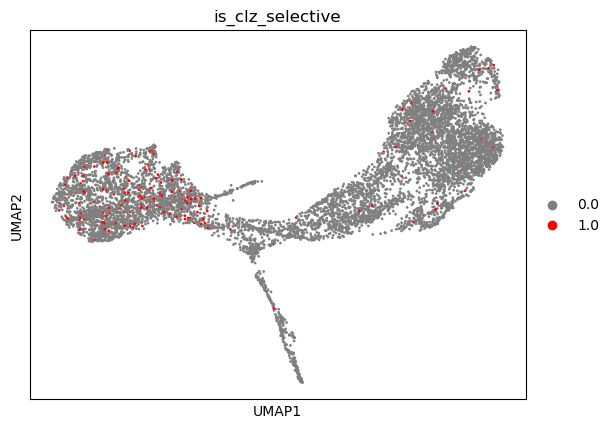

In [14]:
sc.pl.umap(adata, color=["is_clz_selective"],palette=["grey","red"])

In [25]:
adata.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 7745 × 22414
    obs: 'CX3CR1_raw', 'CLDN5_raw', 'GLUL_raw', 'NDRG2_raw', 'PCDH15_raw', 'PLP1_raw', 'MBP_raw', 'SATB2_raw', 'SLC17A7_raw', 'SLC17A6_raw', 'GAD2_raw', 'GAD1_raw', 'SNAP25_raw', 'HTR1A_raw', 'HTR1B_raw', 'HTR1D_raw', 'HTR2A_raw', 'HTR2B_raw', 'HTR2C_raw', 'HTR3A_raw', 'HTR4_raw', 'HTR5A_raw', 'HTR6_raw', 'HTR7_raw', 'DRD1_raw', 'DRD2_raw', 'DRD3_raw', 'DRD5_raw', 'HRH1_raw', 'HRH2_raw', 'HRH3_raw', 'CHRM1_raw', 'CHRM2_raw', 'CHRM3_raw', 'ADRA1A_raw', 'ADRA1B_raw', 'ADRA2A_raw', 'ADRA2B_raw', 'ADRA2C_raw', 'ADRB1_raw', 'ADRB2_raw', 'NOS1_raw', 'CAMK2A_raw', 'CAMK2B_raw', 'ETV1_raw', 'RXFP1_raw', 'PDYN_raw', 'kmeans', 'louvain', 'leiden', 'cAMP_CHLORPROMAZINE', 'Ca_CHLORPROMAZINE', 'cAMP_FLUPHENAZINE', 'Ca_FLUPHENAZINE', 'cAMP_HALOPERIDOL', 'Ca_HALOPERIDOL', 'cAMP_ZOTEPINE', 'Ca_ZOTEPINE', 'cAMP_RISPERIDONE', 'Ca_RISPERIDONE', 'cAMP_QUETIAPINE', 'Ca_QUETIAPINE', 'cAMP_OLANZAPINE', 'Ca_OLANZAPINE', 'cAMP_

In [15]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

label_include_list=["plane","water_sated"]
#label_include_list=["hypovolemic_thirst","osmotic_thirst","water_deprivation"]
adata_sated=adata[adata.obs['label'].isin(label_include_list)]
# is_thirstがTrue（または1）のデータをフィルタリング
thirsty_cells = adata_sated[adata_sated.obs['is_thirst'] == 1]

# 長い形式（long-form）にデータを整形
long_df = pd.melt(thirsty_cells.obs, id_vars=['is_thirst'], value_vars=['cAMP_CLOZAPINE', 'cAMP_OLANZAPINE','cAMP_HALOPERIDOL'])

# value=0のcellを除外
long_df=long_df[long_df.value!=0]

# ボックスプロットを作成する
plt.figure(figsize=(10, 6))
#sns.boxplot(data=long_df, x='variable', y='value',whis=(25,75),
#            showfliers=True,notch=True,medianprops={"color": "r", "linewidth": 2})
sns.violinplot(data=long_df, x='variable', y='value')
plt.title('Comparison of cAMP_CLOZAPINE and cAMP_OLANZAPINE in Thirsty Cells')
plt.xlabel('Treatment')
plt.ylabel('cAMP Levels')
plt.show()

# 統計検定
clozapine_values = thirsty_cells.obs['cAMP_CLOZAPINE']
olanzapine_values = thirsty_cells.obs['cAMP_OLANZAPINE']

# t-test
t_stat, t_pval = stats.ttest_ind(clozapine_values, olanzapine_values, equal_var=False)

# Mann-Whitney U test
u_stat, u_pval = stats.mannwhitneyu(clozapine_values, olanzapine_values)

print(f"T-test statistic: {t_stat}, p-value: {t_pval}")
print(f"Mann-Whitney U test statistic: {u_stat}, p-value: {u_pval}")

KeyError: 'label'

In [94]:
long_df

,is_thirst,variable,value
3,1,cAMP_CLOZAPINE,16.399746
13,1,cAMP_CLOZAPINE,8.199873
32,1,cAMP_CLOZAPINE,312.375738
33,1,cAMP_CLOZAPINE,-4.117768
37,1,cAMP_CLOZAPINE,35.091476
...,...,...,...
6965,1,cAMP_OLANZAPINE,-48.906165
6966,1,cAMP_OLANZAPINE,-288.216217
6967,1,cAMP_OLANZAPINE,1.333333
6968,1,cAMP_OLANZAPINE,-213.264323
